# Netflix Data: Cleaning, Analysis and Visualization

1) Load & initial inspection

In [9]:
import pandas as pd
import numpy as np
import os

# Download sample Netflix dataset if not present
if not os.path.exists("netflix.csv"):
	url = "https://raw.githubusercontent.com/prasertcbs/basic-dataset/master/netflix_titles.csv"
	df = pd.read_csv(url)
	df.to_csv("netflix.csv", index=False)
else:
	df = pd.read_csv("netflix.csv")

df.shape, df.columns
df.head()
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

2) Basic cleaning (drop dups, normalize placeholders, parse dates)

In [10]:
# 1. remove exact duplicate rows
df = df.drop_duplicates()

# 2. normalize common placeholders
df = df.replace({'Not Given':'', 'Not given':'', '': np.nan})

# 3. parse date_added robustly (coerce invalid to NaT)
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# 4. create derived date columns
df['year_added']  = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month
df['day_added']   = df['date_added'].dt.day


3) Handle multi-valued columns (country, listed_in → genres)

In [11]:
# Make lists for multi-value columns
df['country_list'] = df['country'].fillna('').apply(lambda x: [c.strip() for c in x.split(',') if c.strip()])
df['genres'] = df['listed_in'].fillna('').apply(lambda x: [g.strip() for g in x.split(',') if g.strip()])
# A quick exploded table for country counts:
countries = pd.Series([c for sub in df['country_list'] for c in sub]).value_counts()


4) Parse duration into numeric fields

In [12]:
def parse_duration(x):
    if pd.isna(x): return np.nan
    x = str(x).strip()
    if 'min' in x:
        try:
            return int(x.split()[0])
        except: return np.nan
    # handle Seasons: return number of seasons or NaN
    if 'Season' in x:
        try:
            return int(x.split()[0])
        except: return np.nan
    return np.nan

# two fields: minutes (for movies) and seasons (for TV shows)
df['duration_min'] = df['duration'].apply(lambda x: int(x.split()[0]) if isinstance(x,str) and 'min' in x else np.nan)
df['num_seasons'] = df['duration'].apply(lambda x: int(x.split()[0]) if isinstance(x,str) and 'Season' in x else np.nan)


5) Handle missing critical fields sensibly

In [13]:
df['director'] = df['director'].fillna('Unknown')
df['country']  = df['country'].fillna('Unknown')


6) Save cleaned dataset

In [14]:
df.to_csv("netflix_cleaned.csv", index=False)


# Exploratory Analysis ideas

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_1528\1139906945.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


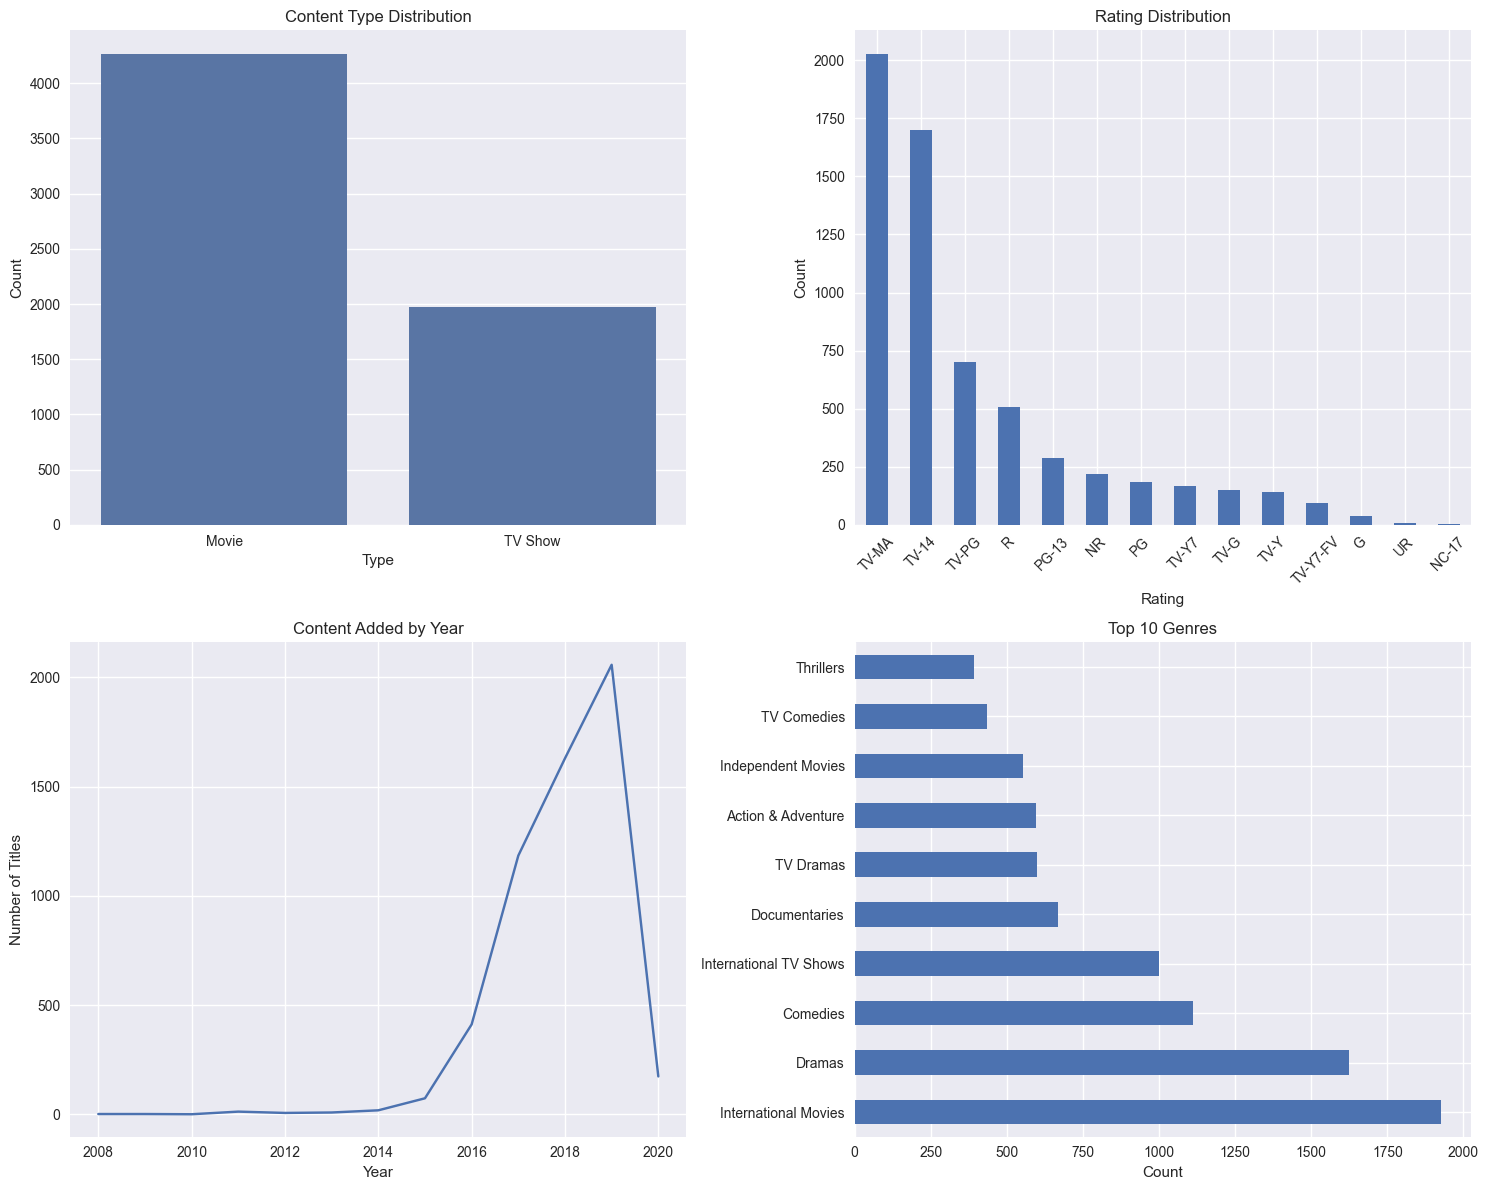

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
plt.style.use('seaborn')

# Create a figure with 2x2 subplots with specified size
fig = plt.figure(figsize=(15, 12))

# Type distribution
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='type')
plt.title('Content Type Distribution')
plt.xlabel('Type')
plt.ylabel('Count')

# Ratings distribution
plt.subplot(2, 2, 2)
df['rating'].value_counts().plot(kind='bar', rot=45)
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')

# Yearly additions
plt.subplot(2, 2, 3)
df['year_added'].value_counts().sort_index().plot(kind='line')
plt.title('Content Added by Year')
plt.xlabel('Year')
plt.ylabel('Number of Titles')

# Top genres
plt.subplot(2, 2, 4)
genre_counts = pd.Series([g for sub in df['genres'] for g in sub]).value_counts()
genre_counts.head(10).plot(kind='barh')
plt.title('Top 10 Genres')
plt.xlabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

# Quality checks & validations

In [18]:
# duplicate show_id?
df['show_id'].duplicated().sum()

# null counts
df.isnull().sum()

# suspicious release years (e.g., > current year or < 1900)
df.loc[(df['release_year'] < 1900) | (df['release_year'] > 2025), 'release_year'].unique()

# check date_added vs release_year (e.g., release > date_added is OK but check anomalies)
df[df['date_added'].notna() & (df['release_year'] > df['date_added'].dt.year)]


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,day_added,country_list,genres,duration_min,num_seasons
518,80202352,Movie,Incoming,Eric Zaragosa,"Scott Adkins, Aaron McCusker, Vahldin Prelic, ...","Serbia, United States",2018-10-26,2019,TV-MA,89 min,"Action & Adventure, Sci-Fi & Fantasy",When an imprisoned terrorist cell hijacks a hi...,2018.0,10.0,26.0,"[Serbia, United States]","[Action & Adventure, Sci-Fi & Fantasy]",89.0,NaN
1315,81034946,TV Show,Maradona in Mexico,Unknown,Diego Armando Maradona,"Argentina, United States, Mexico",2019-11-13,2020,TV-MA,1 Season,"Docuseries, Spanish-Language TV Shows","In this docuseries, soccer great Diego Maradon...",2019.0,11.0,13.0,"[Argentina, United States, Mexico]","[Docuseries, Spanish-Language TV Shows]",NaN,1.0
2028,70259177,TV Show,Jack Taylor,Stuart Orme,"Iain Glen, Killian Scott, Nora-Jane Noone, Tar...","United States, Ireland",2013-03-31,2016,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Dramas",Ken Bruen's bestselling crime novels leap to l...,2013.0,3.0,31.0,"[United States, Ireland]","[Crime TV Shows, International TV Shows, TV Dr...",NaN,1.0
3144,80190946,Movie,Hans Teeuwen: Real Rancour,Doesjka van Hoogdalem,Hans Teeuwen,Netherlands,2017-07-01,2018,TV-MA,86 min,Stand-Up Comedy,Comedian Hans Teeuwen rebels against political...,2017.0,7.0,1.0,[Netherlands],[Stand-Up Comedy],86.0,NaN
4587,80091880,TV Show,Tokyo Trial,Unknown,"Marcel Hensema, Paul Freeman, Irrfan Khan, Sta...","Canada, Japan, Netherlands",2016-12-13,2017,TV-14,1 Season,"International TV Shows, TV Dramas","In the wake of World War II, 11 Allied judges ...",2016.0,12.0,13.0,"[Canada, Japan, Netherlands]","[International TV Shows, TV Dramas]",NaN,1.0
4662,80229852,TV Show,Little Singham,Unknown,"Swapnil Kumari, Jigna Bhardwaj, Sonal Kaushal,...",Unknown,2018-12-01,2019,TV-Y7,1 Season,"Kids' TV, TV Comedies","A spinoff of Rohit Shetty's action franchise, ...",2018.0,12.0,1.0,[],"[Kids' TV, TV Comedies]",NaN,1.0
